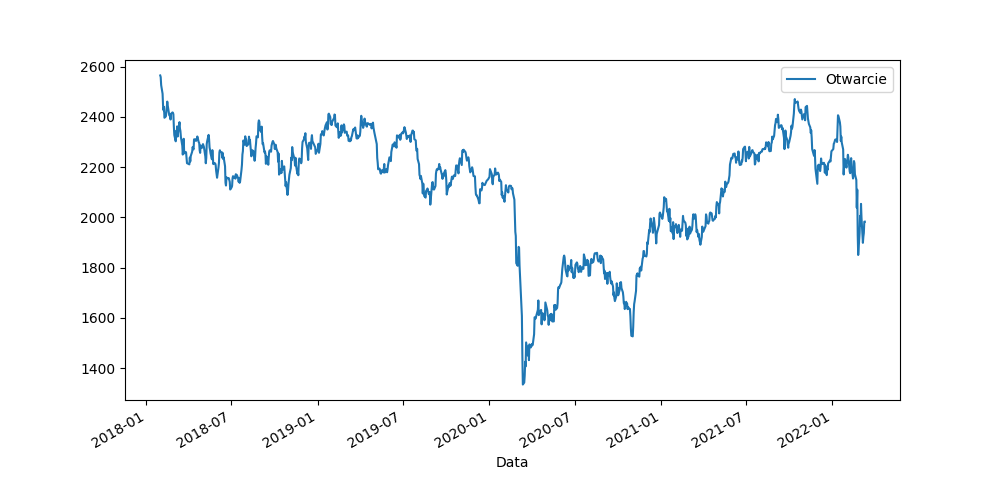

In [136]:
import os
import csv
import pandas as pd

import matplotlib.pylab as plt
from datetime import datetime, timedelta

# loading csv file as DataFrame
df = pd.read_csv('data.csv', usecols=['Data', 'Otwarcie'])

plt.rcParams['figure.figsize'] = [10, 5]
df['Data'] = pd.to_datetime(df['Data'])

df.plot(x=0, y=1)
plt.show()

## Funkcja wyliczająca EMA
Funkcja calculate_EMA wyliczba EMA dla wartości Otwarcia dnia podanego jako argument day. Dodatkowo ustawiając argument signal na True, możemy policzyć EMA dla wartości MACD

In [128]:
def calculate_EMA (dataFrame, day, N, signal=False):
    end_index = df.index[df.Data == day]

    if end_index[0] - 27 < 0:
        #N += end_index[0] - N
        return 0

    beg_index = end_index - N - 1
    #print(beg_index, end_index, N)

    alpha = 2 / (N + 1)
    top = 0
    bot = 0
    i = 0

    # selecting only dates that will be used
    frame = dataFrame[beg_index[0]: end_index[0]]
    frame = frame.sort_values(by=['Data'], ascending=False)

    for index, p in frame.iterrows():
        if signal:
            top += p['MACD'] * pow(1-alpha, i)
        else:
            top += p['Otwarcie'] * pow(1-alpha, i)
        bot += pow((1-alpha), i)
        i += 1

    if bot == 0:
        return 0

    EMA=top/bot
    return EMA    

## Wyznaczenie wartości MACD i SIGNAL dla poszczególnych dni

In [131]:
df['MACD'] = 0.0
df['SIGNAL'] = 0.0

for (index, row) in df.iterrows():
    df.loc[index, 'MACD'] = calculate_EMA(df, row['Data'], 12) - calculate_EMA(df, row['Data'], 26)
    df.loc[index, 'SIGNAL'] = calculate_EMA(df, row['Data'], 9, True)

## Wizualizacja MACD i SIGNAL

In [130]:
#calculate_EMA(df, df.loc[29]['Data'], 12)
df.head(29)

,Data,Otwarcie,MACD,SIGNAL
0,2018-01-31,2565.29,0.000000,0.000000
1,2018-02-01,2558.83,0.000000,0.000000
2,2018-02-02,2526.55,0.000000,0.000000
3,2018-02-05,2492.39,0.000000,0.000000
4,2018-02-06,2445.53,0.000000,0.000000
5,2018-02-07,2426.89,0.000000,0.000000
6,2018-02-08,2440.29,0.000000,0.000000
7,2018-02-09,2396.78,0.000000,0.000000
8,2018-02-12,2402.18,0.000000,0.000000
9,2018-02-13,2417.65,0.000000,0.000000


In [94]:
df

,Data,Otwarcie,MACD,SIGNAL
0,2018-01-31,2565.29,0.000000,0.000000
1,2018-02-01,2558.83,0.000000,0.000000
2,2018-02-02,2526.55,0.000000,0.000000
3,2018-02-05,2492.39,0.000000,0.000000
4,2018-02-06,2445.53,0.000000,0.000000
...,...,...,...,...
1022,2022-03-07,1898.74,-68.307396,-65.476590
1023,2022-03-08,1922.98,-75.724776,-67.504550
1024,2022-03-09,1937.96,-77.751399,-70.492854
1025,2022-03-10,1983.05,-76.225257,-73.339972


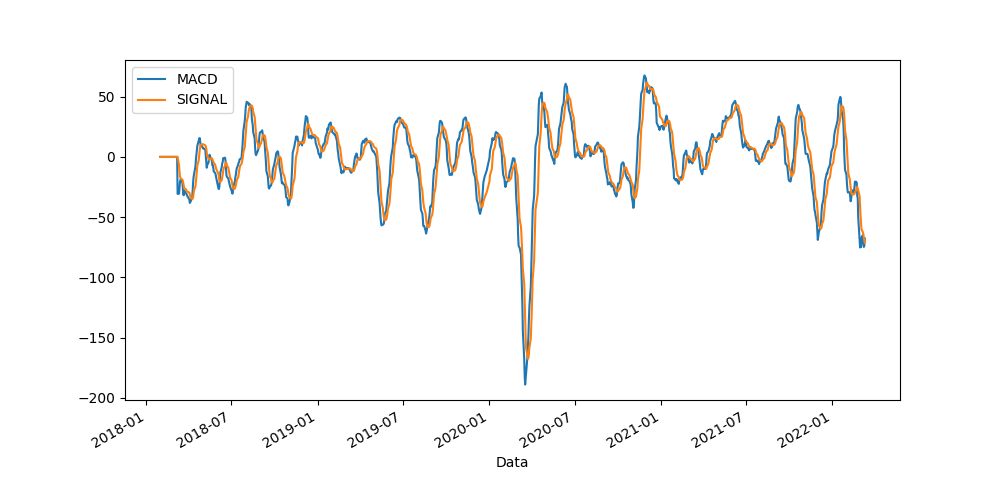

In [133]:
%matplotlib widget
ax = df.plot(x=0, y=2)
df.plot(x=0, y=3, ax=ax)
plt.show()


# Algorytm który na podstawie MACD podejmuje decyzje o kupnie/sprzedaży
1. Oblicza wartość MACD i SIGNAL w danym dniu
2. Analizuje wartości i stwierdza czy jest to sygnał sprzedarzy czy kupna
3. Kupuje / sprzedaje

In [124]:
# analyzes data
# return 0  : not time to take action
# return 1  : time tu buy
# return -1 : time to sell
def analyze_data(data, index):
    tolerance = 0.5
    if index < 1:
        return 0
    nowMACD = data.loc[index, 'MACD']
    nowSIG = data.loc[index, 'SIGNAL'] 
    preMACD = data.loc[index -1, 'MACD']
    preSIG = data.loc[index-1, 'SIGNAL'] 
    
    if (nowMACD <nowSIG-tolerance/2) and (nowMACD > nowSIG + tolerance/2):
        return 0
    
    if preSIG < preMACD:
        return 1
    return -1

def buy(founds, shares_nbr, price):
    
    amount = int((founds / price) * 100) / 100
    founds -=amount * price
    founds = int(founds * 100) / 100
    shares_nbr += amount
    return founds, shares_nbr
    
def sell(founds, shares_nbr, price):
    founds += shares_nbr * price
    founds = int(founds * 100) / 100
    shares_nbr = 0
    return founds, shares_nbr

In [125]:
founds = 1000
shares_nbr = 0
is_in = False

df['ACTION'] = 0

for (index, row) in df.iterrows():
    df.loc[index, 'MACD'] = calculate_EMA(df, row['Data'], 12) - calculate_EMA(df, row['Data'], 26)
    df.loc[index, 'SIGNAL'] = calculate_EMA(df, row['Data'], 9, True)
    action = analyze_data(df, index)
    
    
    if action == 1 and not is_in:
        founds, shares_nbr = buy(founds, shares_nbr, df.loc[index, 'Otwarcie'])
        is_in = True
        df.loc[index, 'ACTION'] = 1
#         print(founds)
    elif action == -1 and is_in:
        founds, shares_nbr = sell(founds, shares_nbr, df.loc[index, 'Otwarcie'])
        is_in=False
        df.loc[index, 'ACTION'] = -1
        print(founds)

if shares_nbr != 0:
     founds, shares_nbr =sell(founds, shares_nbr, df.iloc[-1:]['Otwarcie'])
    
print("Kapitał po inwestowaniu przy pomocy MACD:", founds)

998.71
993.93
950.43
996.04
945.65
892.26
891.04
893.84
883.2
896.77
887.61
879.7
869.12
926.72
957.35
992.08
1006.21
915.09
1019.0
1115.48
1092.16
1086.64
1051.48
1169.46
1156.88
1108.35
1122.49
1088.64
1089.51
1186.89
1205.28
1208.16
1224.97
1246.31
1282.72
1303.28
1167.8
Kapitał po inwestowaniu przy pomocy MACD: 1167.8


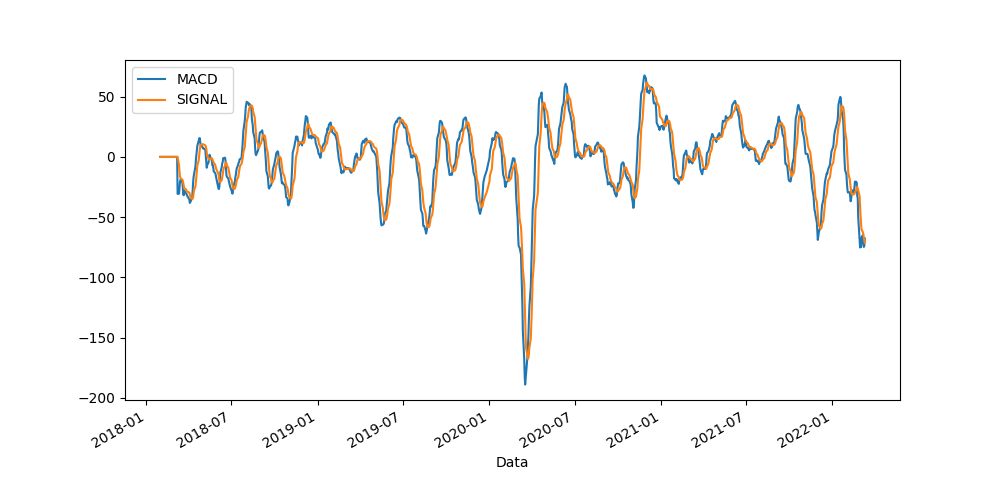

In [118]:
ax = df.plot(x=0, y=2)
cx = df.plot(x=0, y=3, ax=ax)


<AxesSubplot:xlabel='Data', ylabel='SIGNAL'>

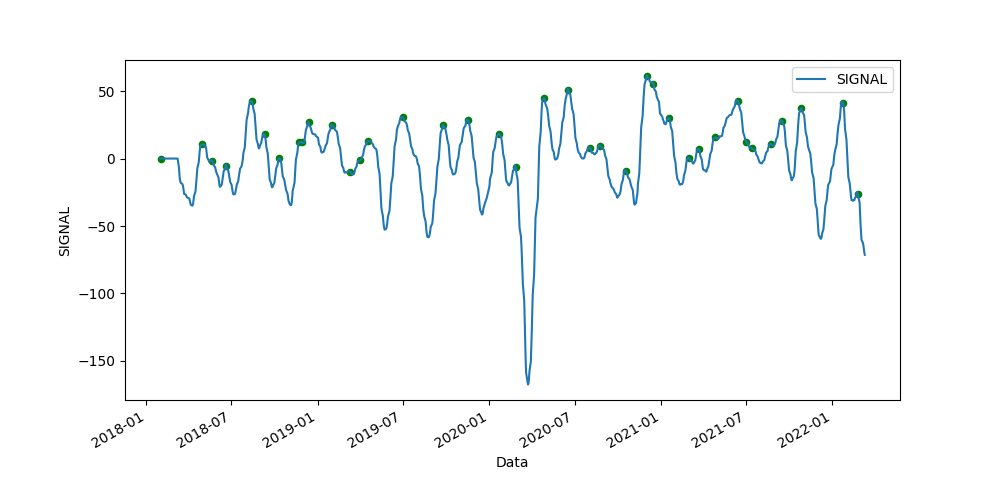

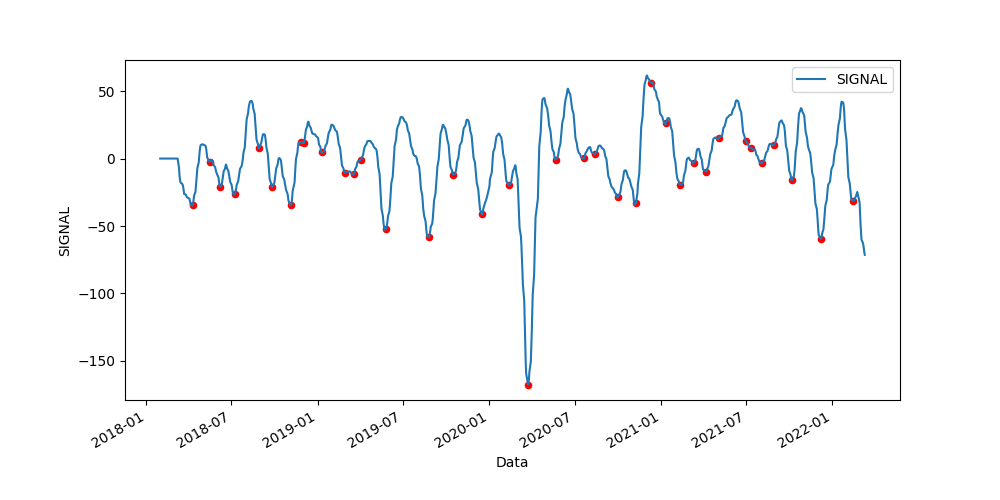

In [121]:
buying = df[df['ACTION'] == 1]
selling = df[df['ACTION'] == -1]

bx = buying.plot.scatter(x=0, y=3,c='Green')
ax = df.plot(x=0, y=3, ax=bx)

sx = selling.plot.scatter(x=0, y=3, c='Red')
df.plot(x=0, y=3, ax=sx)
